In [ ]:
# connect to google drive
import os
from google.colab import drive
ROOT_PATH = os.path.join(os.sep, 'content' , 'gdrive')
drive.mount(ROOT_PATH, force_remount = True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/ProgettoAI/ProgettoAI/SteRoom

/content/gdrive/MyDrive/ProgettoAI/ProgettoAI/SteRoom


### Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import random
from PIL import Image
import warnings
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import filters
from skimage.color import rgb2gray
from tensorflow.keras.optimizers import Adam

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

warnings.filterwarnings('ignore')

2.9.2


### Seed

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

### Loading Image Dataset

In [ ]:
data_dir = '/content/gdrive/MyDrive/ProgettoAI/ProgettoAI/Processed_dataset'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
# Input Parameters
img_w = 256
img_h = 256
classes = 3
batch_size = 32

In [ ]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator()

training_set = datagen.flow_from_directory(
        directory = training_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = True
    )

validation_set = datagen.flow_from_directory(
        directory = validation_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = False
    )

test_set = datagen.flow_from_directory(
        directory = test_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = False
    )

Found 10834 images belonging to 3 classes.
Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


### Import Frozen Model

In [ ]:
frozen_tl_model = tfk.models.load_model('effB3_frozen')
frozen_tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  
                                                                 
 gap (GlobalAveragePooling2D  (None, 1536)             0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

### Fine Tuning

In [ ]:
# Set all EfficientNetB3 layers to True
frozen_tl_model .get_layer('efficientnetb3').trainable = True

In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(frozen_tl_model.get_layer('efficientnetb3').layers):
  layer.trainable = True
for i, layer in enumerate(frozen_tl_model.get_layer('efficientnetb3').layers):
   print(i, layer.name, layer.trainable)
frozen_tl_model.summary()

0 input_1 True
1 rescaling True
2 normalization True
3 tf.math.truediv True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_expand True
41 bl

In [ ]:
finetuned_model = frozen_tl_model
finetuned_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(10**-5), metrics='accuracy')
finetuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  
                                                                 
 gap (GlobalAveragePooling2D  (None, 1536)             0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

### Model Training

In [ ]:
# Callback
learningrate = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.1, min_lr=1e-8)

In [ ]:
# Train the model
history = finetuned_model.fit(
    x = training_set,
    epochs = 20,
    validation_data = validation_set,
    callbacks = learningrate
).history

Epoch 1/20
339/339 [==============================] - 2747s 8s/step - loss: 0.3951 - accuracy: 0.8825 - val_loss: 0.3105 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 2/20
339/339 [==============================] - 267s 787ms/step - loss: 0.1675 - accuracy: 0.9348 - val_loss: 0.1806 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 3/20
339/339 [==============================] - 266s 786ms/step - loss: 0.1250 - accuracy: 0.9575 - val_loss: 0.1189 - val_accuracy: 0.9527 - lr: 0.0010
Epoch 4/20
339/339 [==============================] - 269s 792ms/step - loss: 0.1080 - accuracy: 0.9595 - val_loss: 0.1584 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 5/20
339/339 [==============================] - 268s 790ms/step - loss: 0.0964 - accuracy: 0.9679 - val_loss: 0.1272 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 6/20
339/339 [==============================] - 267s 786ms/step - loss: 0.0690 - accuracy: 0.9781 - val_loss: 0.1574 - val_accuracy: 0.9553 - lr: 0.0010
Epoch 7/20
339/339 [============================

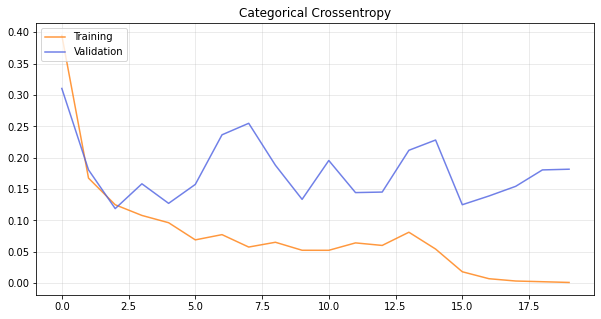

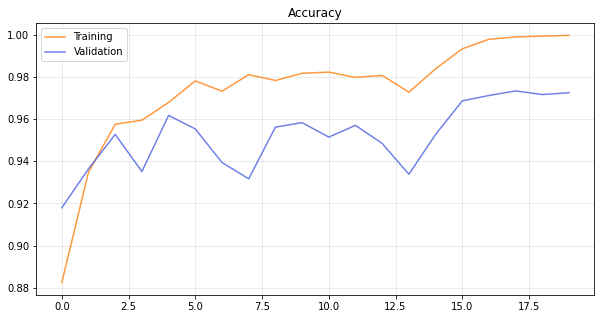

In [ ]:
# Plot the training

# Loss Function
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

### Predictions Evaluation

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

def print_evaluation(y_true, predictions):
    cm = confusion_matrix(y_true, predictions, normalize='pred')
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ['N', 'P', 'T'])
    cm_display.plot()
    
    print(classification_report(y_true, predictions, digits = 4))

In [ ]:
labels = ['N', 'P', 'T']

In [ ]:
y_val = validation_set.labels
y_test = test_set.labels

In [ ]:
val_predictions = finetuned_model.predict(validation_set)
test_predictions = finetuned_model.predict(test_set)

73/73 [==============================] - 595s 8s/step


              precision    recall  f1-score   support

           0     0.9768    0.9796    0.9782      1420
           1     0.9842    0.9795    0.9818       635
           2     0.9225    0.9191    0.9208       272

    accuracy                         0.9725      2327
   macro avg     0.9612    0.9594    0.9603      2327
weighted avg     0.9725    0.9725    0.9725      2327



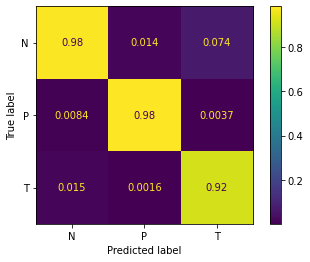

In [ ]:
# Validation
print_evaluation(y_val, np.argmax(val_predictions, axis=-1))

              precision    recall  f1-score   support

           0     0.9709    0.9828    0.9768      1392
           1     0.9842    0.9826    0.9834       634
           2     0.9401    0.8869    0.9127       283

    accuracy                         0.9710      2309
   macro avg     0.9651    0.9508    0.9576      2309
weighted avg     0.9708    0.9710    0.9708      2309



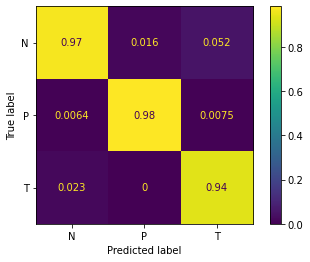

In [ ]:
# Test
print_evaluation(y_test, np.argmax(test_predictions, axis=-1))

### Save Model

In [ ]:
finetuned_model.save('effb3_finetuning_all')